In [1]:
!pip install kagglehub transformers torch

In [2]:
from google.colab import files
files.upload()  # Select the `kaggle.json` file from your system.

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"prabhukumar13","key":"e78bd235a667c9f2597648aa6e104819"}'}

In [3]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
import kagglehub
path = kagglehub.dataset_download("mathurinache/dialogptlarge")
print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/mathurinache/dialogptlarge/versions/1


In [11]:
import os

# Check contents of the downloaded path
files_in_path = os.listdir(path)
print("Files in dataset path:", files_in_path)

Files in dataset path: ['DialoGPT-large']


In [12]:
import kagglehub
path = kagglehub.dataset_download("mathurinache/dialogptlarge")
print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/mathurinache/dialogptlarge/versions/1


100%|██████████| 3/3 [00:02<00:00,  1.20it/s]


Perplexity of the model: 1716.1329345703125


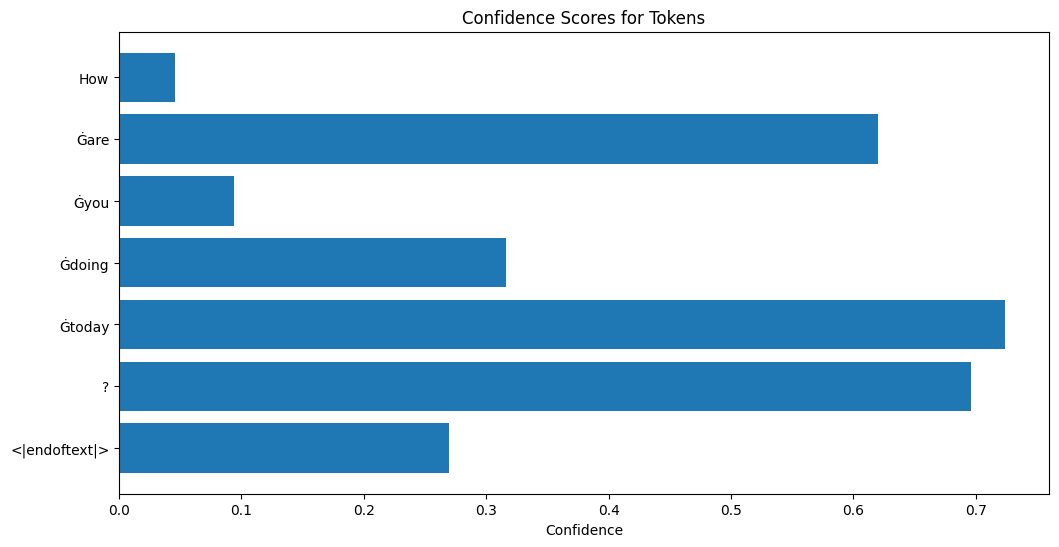

Cosine Similarity: 0.9055970311164856
Start chatting with the bot! Type 'exit' to stop.
You: hey
Bot: Hey, how are you?
You: doing good, what about you?
Bot: I'm doing alright, thanks.
You: your welcome
Bot: I'm glad you're doing well.
You: me to
Bot: I'm glad you're doing well.
You: exit
Ending chat.


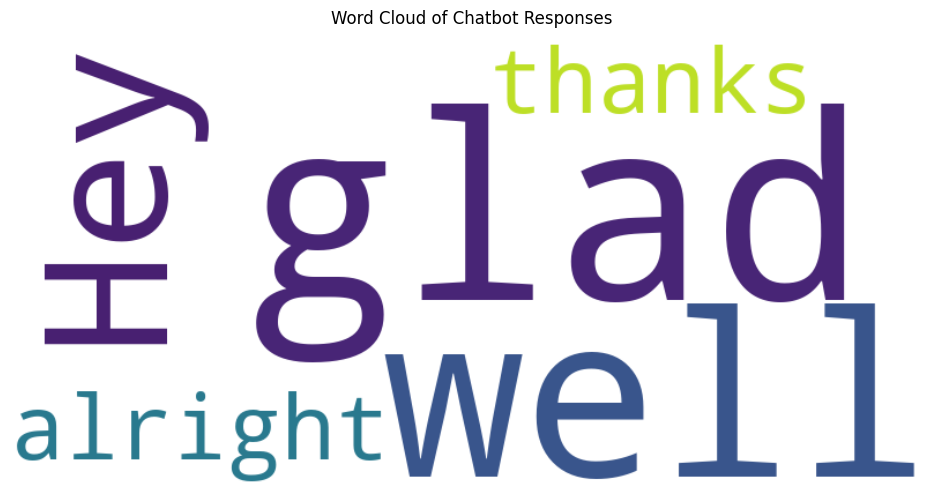

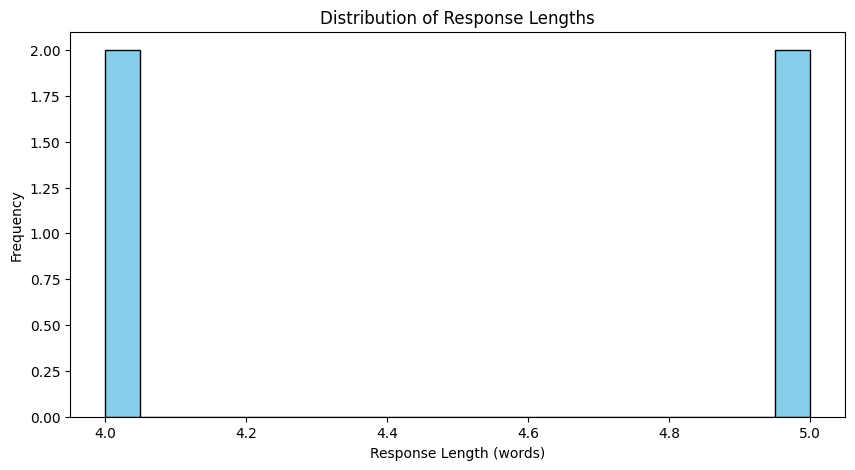

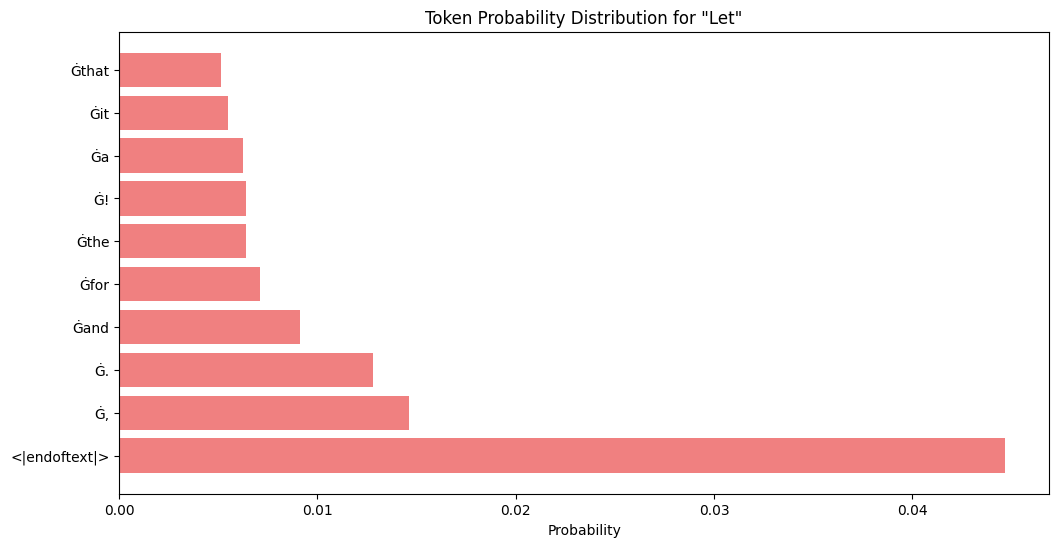

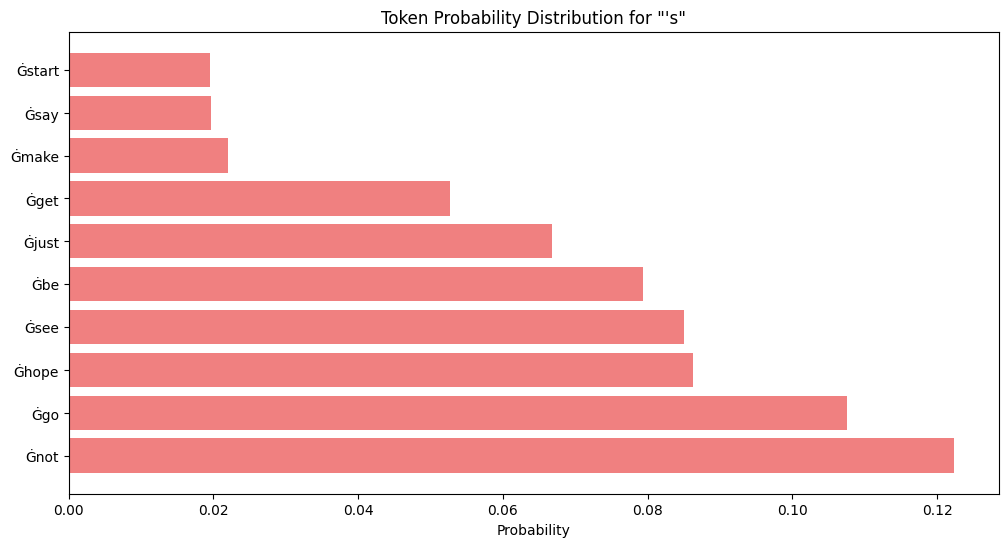

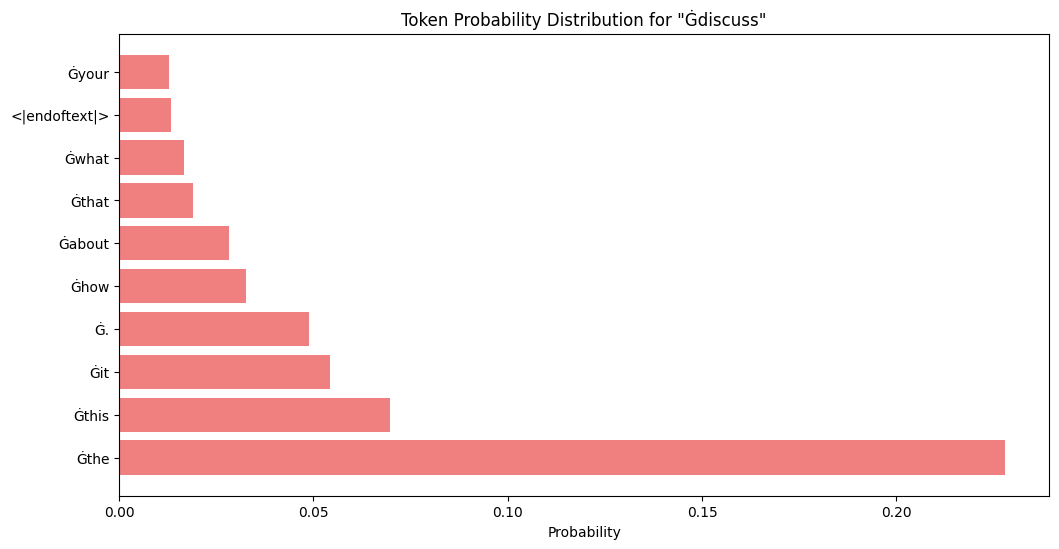

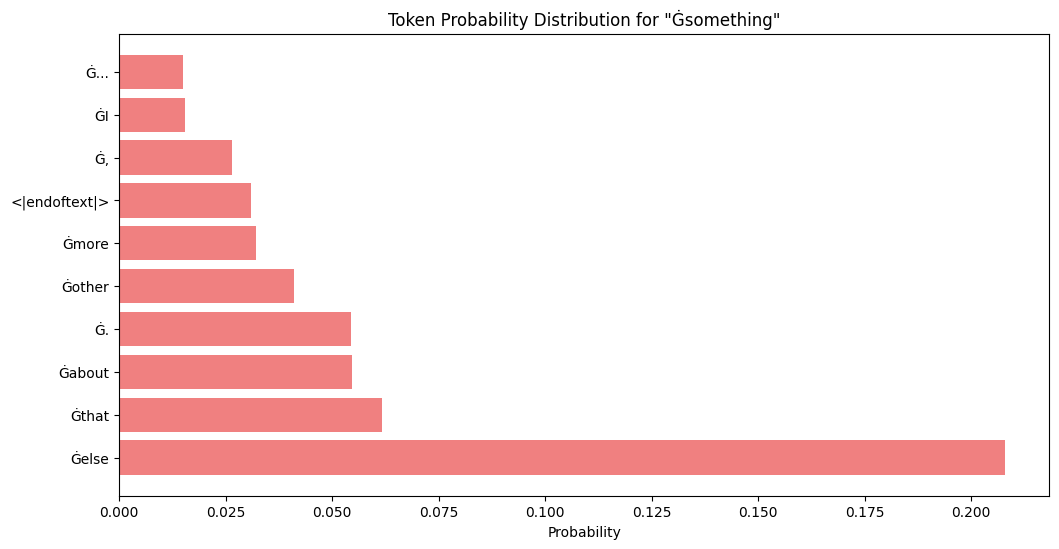

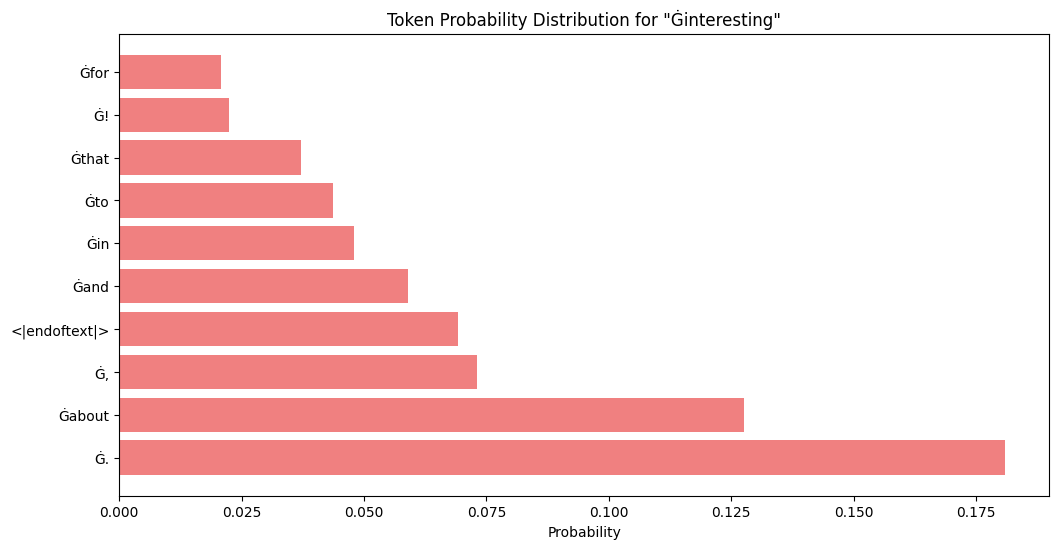

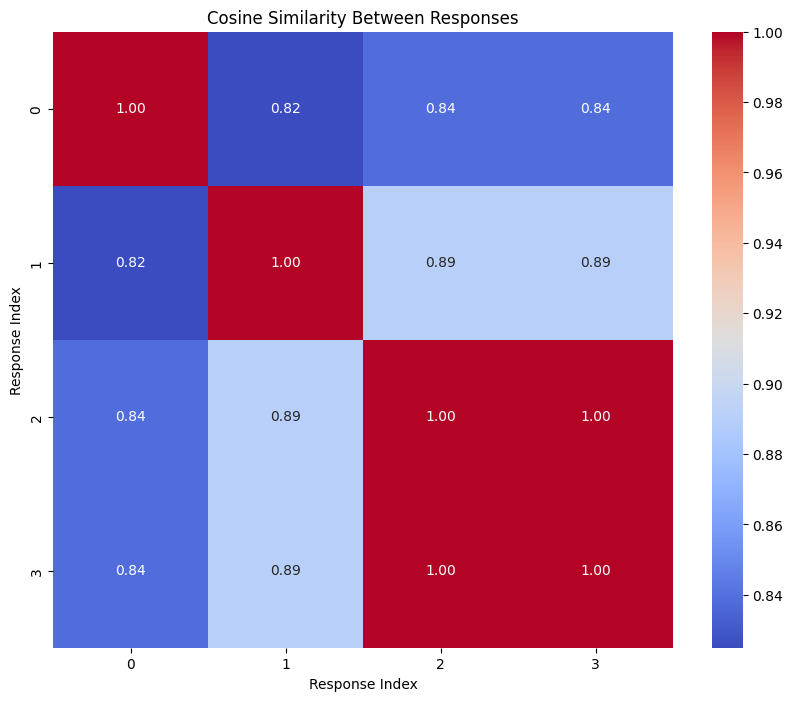

In [14]:
import os
import re
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics.pairwise import cosine_similarity
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch.nn.functional as F
from wordcloud import WordCloud
import seaborn as sns

# Load the model and tokenizer
tokenizer = AutoTokenizer.from_pretrained("microsoft/DialoGPT-large")
model = AutoModelForCausalLM.from_pretrained("microsoft/DialoGPT-large")

# Function to clean input text
def clean_text(text):
    # Remove any URLs, special characters, or extra whitespaces
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

# Function to tokenize dialogues
def tokenize_dialogues(dialogues):
    # Tokenize each dialogue in the dataset
    tokenized_data = []
    for dialogue in dialogues:
        cleaned_text = clean_text(dialogue)
        inputs = tokenizer.encode(cleaned_text + tokenizer.eos_token, return_tensors="pt")
        tokenized_data.append(inputs)
    return tokenized_data

# Function to calculate perplexity of the model
def calculate_perplexity(tokenized_data):
    model.eval()  # Set the model to evaluation mode
    total_loss = 0.0
    num_tokens = 0

    with torch.no_grad():
        for inputs in tqdm(tokenized_data):
            outputs = model(inputs, labels=inputs)
            loss = outputs.loss
            num_tokens += inputs.size(1)
            total_loss += loss.item() * inputs.size(1)

    perplexity = torch.exp(torch.tensor(total_loss / num_tokens))
    return perplexity.item()

# Function to plot training loss graph
def plot_loss_graph(loss_values):
    plt.figure(figsize=(10, 5))
    plt.plot(range(len(loss_values)), loss_values, label='Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss Over Time')
    plt.legend()
    plt.show()

# Function to visualize token confidence
def visualize_token_confidence(text):
    inputs = tokenizer.encode(text + tokenizer.eos_token, return_tensors="pt")
    outputs = model(inputs)
    logits = outputs.logits[0]

    # Convert logits to probabilities
    probs = F.softmax(logits, dim=-1)

    # Visualize confidence scores for each token
    tokens = tokenizer.convert_ids_to_tokens(inputs[0])
    confidences = [probs[i].max().item() for i in range(len(tokens))]

    plt.figure(figsize=(12, 6))
    plt.barh(range(len(tokens)), confidences, tick_label=tokens)
    plt.xlabel('Confidence')
    plt.title('Confidence Scores for Tokens')
    plt.gca().invert_yaxis()
    plt.show()

# Function to compute cosine similarity between responses
def compute_cosine_similarity(response1, response2):
    enc1 = tokenizer.encode(response1, return_tensors='pt')
    enc2 = tokenizer.encode(response2, return_tensors='pt')
    vec1 = model.transformer.wte(enc1).mean(dim=1).detach().numpy()  # Embeddings for response1
    vec2 = model.transformer.wte(enc2).mean(dim=1).detach().numpy()  # Embeddings for response2

    # Compute cosine similarity
    similarity = cosine_similarity(vec1, vec2)
    return similarity[0][0]

# Function to generate word cloud for frequent words in chatbot responses
def generate_word_cloud(responses):
    text = " ".join(responses)
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

    plt.figure(figsize=(12, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title('Word Cloud of Chatbot Responses')
    plt.show()

# Function to plot response length distribution
def plot_response_length_distribution(responses):
    lengths = [len(response.split()) for response in responses]

    plt.figure(figsize=(10, 5))
    plt.hist(lengths, bins=20, color='skyblue', edgecolor='black')
    plt.xlabel('Response Length (words)')
    plt.ylabel('Frequency')
    plt.title('Distribution of Response Lengths')
    plt.show()

# Function to visualize token probability distribution
def visualize_token_probability_distribution(text):
    inputs = tokenizer.encode(text + tokenizer.eos_token, return_tensors="pt")
    outputs = model(inputs)
    logits = outputs.logits[0]
    probs = F.softmax(logits, dim=-1)

    # Plot probability distribution for the first few tokens
    for idx, token in enumerate(tokenizer.convert_ids_to_tokens(inputs[0][:5])):
        plt.figure(figsize=(12, 6))
        token_probs = probs[idx].detach().cpu().numpy()
        top_indices = np.argsort(token_probs)[-10:]  # Top 10 predictions
        top_probs = token_probs[top_indices]
        top_tokens = [tokenizer.convert_ids_to_tokens([i])[0] for i in top_indices]

        plt.barh(top_tokens, top_probs, color='lightcoral')
        plt.xlabel('Probability')
        plt.title(f'Token Probability Distribution for "{token}"')
        plt.gca().invert_yaxis()
        plt.show()

# Function to generate a heatmap of response similarities
def generate_similarity_heatmap(responses):
    # Get the embedding of each response, ensuring it's in the correct format
    encodings = []
    for response in responses:
        enc = tokenizer.encode(response, return_tensors='pt')
        embedding = model.transformer.wte(enc).mean(dim=1)  # Average token embeddings
        encodings.append(embedding.squeeze().detach().numpy())  # Remove extra dimensions

    # Convert the list of encodings to a 2D numpy array
    encodings_2d = np.array(encodings)

    # Compute cosine similarities
    similarities = cosine_similarity(encodings_2d)

    # Generate the heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(similarities, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title('Cosine Similarity Between Responses')
    plt.xlabel('Response Index')
    plt.ylabel('Response Index')
    plt.show()

# Chat loop
def chat():
    print("Start chatting with the bot! Type 'exit' to stop.")
    chat_history_ids = None  # Track conversation history
    responses = []  # Store bot responses for further analysis

    while True:
        # Take user input
        input_text = input("You: ")
        if input_text.lower() in ["exit", "quit"]:
            print("Ending chat.")
            break

        # Encode the new user input and add end-of-sequence token
        new_input_ids = tokenizer.encode(input_text + tokenizer.eos_token, return_tensors="pt")

        # Concatenate the new input with the conversation history
        bot_input_ids = torch.cat([chat_history_ids, new_input_ids], dim=-1) if chat_history_ids is not None else new_input_ids

        # Generate a response using the model
        bot_output = model.generate(bot_input_ids, max_length=100, pad_token_id=tokenizer.eos_token_id)

        # Decode the bot's response
        decoded_response = tokenizer.decode(bot_output[:, bot_input_ids.shape[-1]:][0], skip_special_tokens=True)
        print("Bot:", decoded_response)

        # Store response for analysis
        responses.append(decoded_response)

        # Update the chat history with the bot's response
        chat_history_ids = bot_output

    return responses

# Example usage of evaluation functions
if __name__ == "__main__":
    # Example dialogues (replace with actual dataset)
    dialogues = ["Hello, how are you?", "I am fine, thank you!", "What's the weather like today?"]

    # Tokenize dataset
    tokenized_data = tokenize_dialogues(dialogues)

    # Calculate Perplexity
    perplexity = calculate_perplexity(tokenized_data)
    print(f"Perplexity of the model: {perplexity}")

    # Visualize Token Confidence
    visualize_token_confidence("How are you doing today?")

    # Example Cosine Similarity Calculation
    similarity = compute_cosine_similarity("Hello, how are you?", "Hi, how's it going?")
    print(f"Cosine Similarity: {similarity}")

    # Start Chat and collect responses
    responses = chat()

    # Generate additional visualizations
    generate_word_cloud(responses)
    plot_response_length_distribution(responses)
    visualize_token_probability_distribution("Let's discuss something interesting.")
    generate_similarity_heatmap(responses)
